# Calibration


Import the necessary tools:

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import scipy

In [4]:
#############################################################
# Definition of parameters
#############################################################
# Get parameters from attributes
imgsDirectory = 'calibrationStereo/right*.png'
nbVertical = 6
nbHorizontal = 9

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nbHorizontal*nbVertical,3), np.float32)
objp[:,:2] = np.mgrid[0:nbVertical,0:nbHorizontal].T.reshape(-1,2)
objp *= 33.6

# Arrays to store object points and image points from all the images.
objPoints = [] # 3d point in real world space
rightImgPoints = [] # 2d points in image plane.
leftImgPoints = []

# Read the images in this directory
images = glob.glob(imgsDirectory)
assert images

#############################################################
# Get corners of chessboard
#############################################################
# Finish process if no images are found
if len(images) == 0:        
    print("ERROR: No images found in this input: {}.".format(imgsDirectory))

# Continue otherwise
# Read each image with this description and fit the chessboard squares
numberCornersFound = 0

#while False:
for fname in images:
    # First handle right image
    # Make image to gray scale
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # findChessboardCorners
    ret, corners = cv2.findChessboardCorners(gray, (nbVertical, nbHorizontal), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        numberCornersFound += 1
        objPoints.append(objp)

        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        rightImgPoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nbVertical, nbHorizontal), corners2, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

    # Then handle left image
    fname.replace('right', 'left')
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # findChessboardCorners
    ret, corners = cv2.findChessboardCorners(gray, (nbVertical, nbHorizontal), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        numberCornersFound += 1

        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        leftImgPoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nbVertical, nbHorizontal), corners2, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

#############################################################
# Compute calibration parameters
#############################################################
# Finish process if no corners are found
if numberCornersFound == 0:
    print("ERROR: No corners fit in any chessboard image.")
    
# Otherwise continue
# Compute the calibration parameters and show an example image if wanted
print("Found {} number of corners.".format(numberCornersFound))

Found 100 number of corners.


In [5]:
# Calibrate left camera
l_ret, l_mtx, l_dist, l_rvecs, l_tvecs = cv2.calibrateCamera(objPoints, leftImgPoints, gray.shape[::-1], None, None)

# Calibrate right camera
r_ret, r_mtx, r_dist, r_rvecs, r_tvecs = cv2.calibrateCamera(objPoints, rightImgPoints, gray.shape[::-1], None, None)

In [6]:
# Stereo calibration
retval, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F = \
    cv2.stereoCalibrate(objPoints, leftImgPoints, rightImgPoints, l_mtx, l_dist, r_mtx, r_dist, \
                        gray.shape[::-1], flags=cv2.CALIB_FIX_INTRINSIC, criteria=criteria)

In [7]:
# Rectification
R1,R2,P1,P2,Q,validPixROI1,validPixROI2 = cv2.stereoRectify(l_mtx, l_dist, r_mtx, r_dist, gray.shape[::-1], R, T)

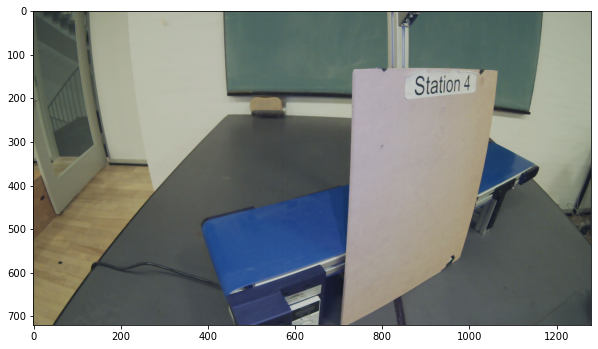

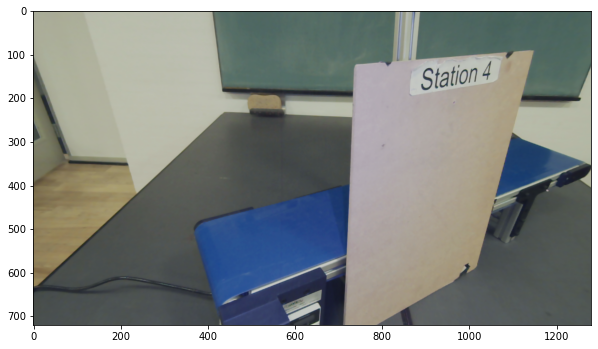

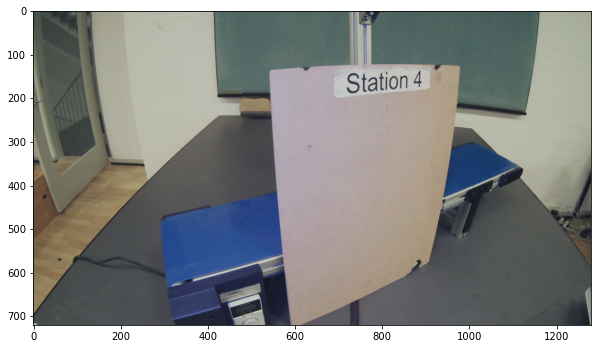

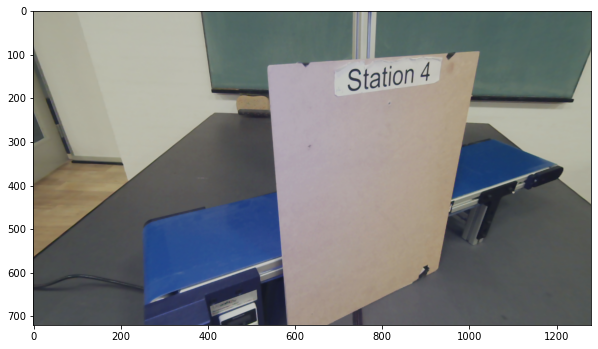

In [66]:
# Calibrate image as example
left = cv2.imread('undistortedImagesWithOcclusion/left/1585434750_405124664_Left.png')
left = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)

lH,  lW = left.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(l_mtx, l_dist, (lW, lH), 1, (lW, lH))

# Undistort
l_dst = cv2.undistort(left, l_mtx, l_dist, P1)

l_gray = cv2.cvtColor(l_dst, cv2.COLOR_RGB2GRAY)

# crop the image
#x, y, w, h = roi
#dst = dst[y:y+h, x:x+w]
plt.figure(figsize=(10,10))
plt.imshow(left)
plt.figure(figsize=(10,10))
plt.imshow(l_dst)

# Calibrate image as example
right = cv2.imread('undistortedImagesWithOcclusion/right/1585434750_405124664_Right.png')
right = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)
rH,  rW = left.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(r_mtx, r_dist, (rW, rH), 1, (rW, rH))

# Undistort
r_dst = cv2.undistort(right, r_mtx, r_dist, P2)

r_gray = cv2.cvtColor(r_dst, cv2.COLOR_RGB2GRAY)

# crop the image
#x, y, w, h = roi
#dst = dst[y:y+h, x:x+w]
plt.figure(figsize=(10,10))
plt.imshow(right)
plt.figure(figsize=(10,10))
plt.imshow(r_dst)

img_size = (int(l_gray.shape[1]/5), int(l_gray.shape[0]/5))
l_gray = cv2.resize(l_gray, img_size, interpolation=cv2.INTER_AREA)
r_gray = cv2.resize(r_gray, img_size, interpolation=cv2.INTER_AREA)

stereo = cv2.StereoSGBM_create(numDisparities=3*16, blockSize=7)
stereo.setMinDisparity(9)
stereo.setDisp12MaxDiff(200)
stereo.setUniquenessRatio(1)
stereo.setSpeckleRange(3)
stereo.setSpeckleWindowSize(5)

# plt.figure(figsize=(10,10))
# disparity = stereo.compute(l_gray,r_gray).astype(np.float32) / 16.0
# plt.imshow(disparity,'gray')
# plt.show()

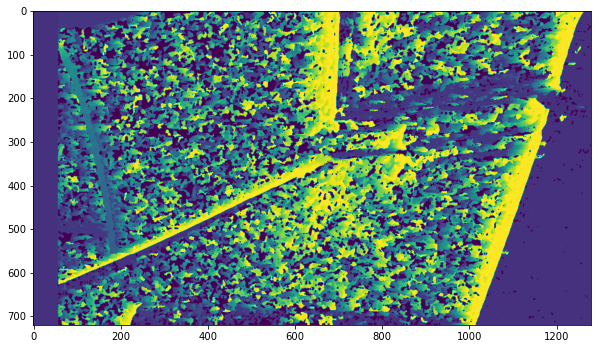

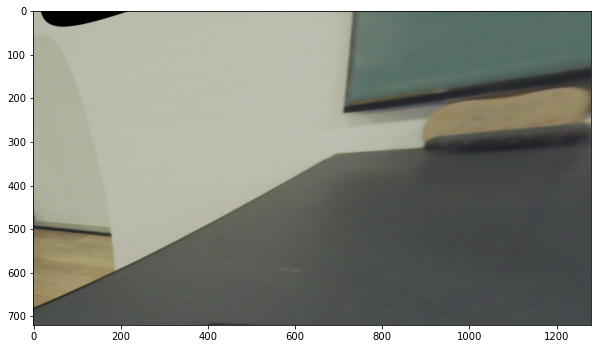

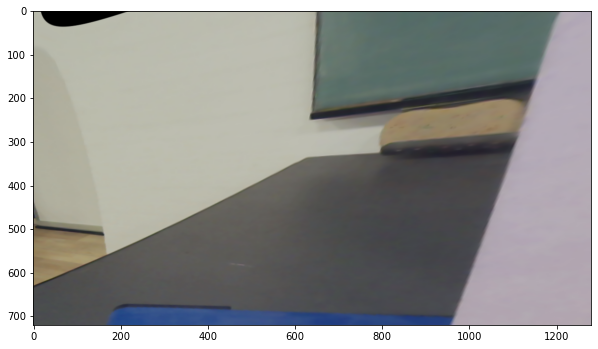

In [69]:
l_map1, l_map2 = cv2.initUndistortRectifyMap(l_mtx, l_dist, R1, P1, (lW,lH), cv2.CV_32FC1)
r_map1, r_map2 = cv2.initUndistortRectifyMap(r_mtx, r_dist, R2, P2, (rW,rH), cv2.CV_32FC1)

l_img = cv2.remap(l_dst, l_map1, l_map2, cv2.INTER_LINEAR)
r_img = cv2.remap(r_dst, r_map1, r_map2, cv2.INTER_LINEAR)


disparity_map = stereo.compute(l_img, r_img)
cv2.filterSpeckles(disparity_map, 0, 64, 32)
plt.figure(figsize=(10,10))
plt.imshow(disparity_map)

plt.figure(figsize=(10,10))
plt.imshow(l_img)
plt.figure(figsize=(10,10))
plt.imshow(r_img)

In [63]:
print(l_mtx)


[[699.99041839   0.         647.56623825]
 [  0.         700.19350622 372.87689429]
 [  0.           0.           1.        ]]
